# 第三小组 

成员以及贡献度排序（“（）”为同贡献度）：占子文 （吴晓山 兰思琪 冯伟珉 德娜勒安尼瓦）

# 概述：决策树 / KNN / 随机森林 比较实验（Heart Disease UCI）

本笔记本演示了在 UCI 心脏病数据集上训练与比较三种经典分类模型：决策树（Decision Tree）、K 近邻（KNN）和随机森林（Random Forest）。

主要内容：

- 数据加载与基本检查：读取 `datasets/heart/heart_disease_uci.csv`，展示数据摘要与缺失值情况。
- 特征与标签划分、训练/测试集拆分（含 stratify）。
- 特征预处理：对 KNN 使用标准化（StandardScaler）。
- 模型训练：训练 DecisionTree、KNeighborsClassifier、RandomForestClassifier 并输出分类报告与混淆矩阵。
- 性能比较：将各模型在测试集上的准确率汇总为表格/柱状图，便于比较。
- 特征重要性：展示决策树与随机森林的特征重要性条形图。
- 可扩展项：网格搜索自动调参、集成投票、SHAP 可解释性分析（如已包含，见后续单元）。

输入：`datasets/heart/heart_disease_uci.csv`。
输出：模型评估报告（classification_report）、混淆矩阵、特征重要性图、模型比较图。

运行说明：
1. 建议在运行前重启 kernel（Kernel → Restart）并从头运行所有单元（Run All）。
2. 依赖库：pandas, numpy, scikit-learn, matplotlib, seaborn（以及可选的 xgboost/shap）。


## UCI心脏病数据集特征说明

- **age**: 年龄
- **sex**: 性别 (1=男性, 0=女性)
- **cp**: 胸痛类型 (0-3)
- **trestbps**: 静息血压 (mm Hg)
- **chol**: 血清胆固醇 (mg/dl)
- **fbs**: 空腹血糖 > 120 mg/dl (1=true, 0=false)
- **restecg**: 静息心电图结果 (0-2)
- **thalach**: 最大心率
- **exang**: 运动诱发心绞痛 (1=yes, 0=no)
- **oldpeak**: ST段压低程度
- **slope**: ST段峰值斜率 (0-2)
- **ca**: 荧光染色的主要血管数量 (0-3)
- **thal**: 地中海贫血类型 (3=normal, 6=fixed defect, 7=reversable defect)
- **num**: 诊断结果 (0=无病, 1=有心脏病)

In [ ]:
# 基础数据处理库
import pandas as pd
import numpy as np

# 数据可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习模型与工具
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    make_scorer
)
from sklearn.datasets import load_iris

# 超参数优化库
import optuna

### 1 读取 Heart Disease UCI 数据集

In [ ]:
# 该数据集可直接从 UCI 官方网站下载或使用 Kaggle 上的副本，本程序使用本地文件）

url = "datasets/heart/heart_disease_uci.csv"
df = pd.read_csv(url)

print("✅ 数据集加载完成！")
print("数据集前 5 行：")
display(df.head())

✅ 数据集加载完成！
数据集前 5 行：


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### 2 数据集概览

In [ ]:
print("\n📊 数据集基本信息：")
print(df.info())
print("\n🧮 缺失值统计：")
print(df.isnull().sum())
print("\n📈 数值特征统计：")
display(df.describe())


📊 数据集基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

🧮 缺失值统计：
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target    

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 3 特征与标签

In [ ]:
# 特征与标签
X = df.drop("target", axis=1)   # 输入特征
y = df["target"]                # 标签 (0: 无心脏病, 1: 有心脏病)

# 拆分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n📚 训练集样本数:", X_train.shape[0])
print("🧪 测试集样本数:", X_test.shape[0])


📚 训练集样本数: 242
🧪 测试集样本数: 61


### 4 决策树模型训练、评估及可视化

In [ ]:
def objective(trial):
    # 扩展参数搜索空间，覆盖更多决策树关键参数
    params = {
        # 最大深度：扩大范围至50，增加过深树的可能性（配合其他参数防止过拟合）
        'max_depth': trial.suggest_categorical('max_depth', [None] + list(range(2, 50))),
        # 最小分裂样本数：从2开始（允许更小的分裂阈值）
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30, step=1),
        # 最小叶节点样本数：从1开始（允许更细的划分）
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20, step=1),
        # 分裂标准：保持gini和entropy
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        # 最大特征数：增加比例型选项（如0.5、0.7）
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.7]),
        # 新增：分裂策略（best=最优分裂，random=随机分裂，后者可防过拟合）
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        # 新增：类别权重（处理类别不平衡，balanced=自动调整权重）
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        # 新增：最大叶节点数（限制叶节点数量，防止树过复杂）
        'max_leaf_nodes': trial.suggest_categorical('max_leaf_nodes', [None] + list(range(5, 100, 5))),
        'random_state': 42
    }
    
    # 构建决策树模型
    dt = DecisionTreeClassifier(** params)
    
    # 优化：使用分层K折交叉验证（保持各折中类别比例一致，更适合分类任务）
   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 计算交叉验证分数
    cv_scores = cross_val_score(
        dt, X_train, y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    return cv_scores.mean()
# 运行贝叶斯优化（增加迭代次数至100，确保覆盖扩展后的参数空间）
study = optuna.create_study(
    direction='maximize',
    study_name='dt_hyperopt_optimized',
    storage=None
)

study.optimize(
    objective,
    n_trials=100,  # 比原60次更多，适配更大的参数空间
    n_jobs=1,
    show_progress_bar=True
)


[I 2025-11-27 20:21:01,390] A new study created in memory with name: dt_hyperopt_optimized
Best trial: 2. Best value: 0.776956:   7%|▋         | 7/100 [00:00<00:01, 62.84it/s]

[I 2025-11-27 20:21:01,406] Trial 0 finished with value: 0.715221088435374 and parameters: {'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 65}. Best is trial 0 with value: 0.715221088435374.
[I 2025-11-27 20:21:01,423] Trial 1 finished with value: 0.7356292517006803 and parameters: {'max_depth': 37, 'min_samples_split': 12, 'min_samples_leaf': 17, 'criterion': 'entropy', 'max_features': None, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 45}. Best is trial 1 with value: 0.7356292517006803.
[I 2025-11-27 20:21:01,440] Trial 2 finished with value: 0.7769557823129252 and parameters: {'max_depth': 45, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_features': None, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 20}. Best is trial 2 with value: 0.7769557823129252.
[I 2025-11-27 20:21:01,455] Trial 3 finished with 

Best trial: 2. Best value: 0.776956:   7%|▋         | 7/100 [00:00<00:01, 62.84it/s]

[I 2025-11-27 20:21:01,518] Trial 7 finished with value: 0.7150510204081633 and parameters: {'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 'log2', 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 65}. Best is trial 2 with value: 0.7769557823129252.


Best trial: 2. Best value: 0.776956:   9%|▉         | 9/100 [00:00<00:01, 62.84it/s]

[I 2025-11-27 20:21:01,535] Trial 8 finished with value: 0.7274659863945578 and parameters: {'max_depth': 49, 'min_samples_split': 28, 'min_samples_leaf': 19, 'criterion': 'entropy', 'max_features': 0.7, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 80}. Best is trial 2 with value: 0.7769557823129252.
[I 2025-11-27 20:21:01,552] Trial 9 finished with value: 0.7266156462585034 and parameters: {'max_depth': 44, 'min_samples_split': 27, 'min_samples_leaf': 16, 'criterion': 'entropy', 'max_features': 0.5, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 85}. Best is trial 2 with value: 0.7769557823129252.


Best trial: 2. Best value: 0.776956:  10%|█         | 10/100 [00:00<00:01, 62.84it/s]

[I 2025-11-27 20:21:01,572] Trial 10 finished with value: 0.7724489795918367 and parameters: {'max_depth': 45, 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 30}. Best is trial 2 with value: 0.7769557823129252.


Best trial: 11. Best value: 0.793282:  16%|█▌        | 16/100 [00:00<00:01, 57.90it/s]

[I 2025-11-27 20:21:01,591] Trial 11 finished with value: 0.79328231292517 and parameters: {'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 30}. Best is trial 11 with value: 0.79328231292517.
[I 2025-11-27 20:21:01,610] Trial 12 finished with value: 0.7851190476190476 and parameters: {'max_depth': 31, 'min_samples_split': 19, 'min_samples_leaf': 7, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 70}. Best is trial 11 with value: 0.79328231292517.
[I 2025-11-27 20:21:01,629] Trial 13 finished with value: 0.7724489795918367 and parameters: {'max_depth': 47, 'min_samples_split': 20, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 70}. Best is trial 11 with value: 0.79328231292517.
[I 2025-11-27 20:21:01,649] Trial 14 fi

Best trial: 11. Best value: 0.793282:  17%|█▋        | 17/100 [00:00<00:01, 57.90it/s]

[I 2025-11-27 20:21:01,709] Trial 17 finished with value: 0.7723639455782313 and parameters: {'max_depth': 31, 'min_samples_split': 18, 'min_samples_leaf': 12, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 30}. Best is trial 11 with value: 0.79328231292517.


Best trial: 19. Best value: 0.801361:  20%|██        | 20/100 [00:00<00:01, 54.14it/s]

[I 2025-11-27 20:21:01,729] Trial 18 finished with value: 0.772704081632653 and parameters: {'max_depth': 35, 'min_samples_split': 23, 'min_samples_leaf': 7, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 11 with value: 0.79328231292517.
[I 2025-11-27 20:21:01,749] Trial 19 finished with value: 0.8013605442176871 and parameters: {'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 19 with value: 0.8013605442176871.


Best trial: 22. Best value: 0.809609:  26%|██▌       | 26/100 [00:00<00:01, 52.94it/s]

[I 2025-11-27 20:21:01,769] Trial 20 finished with value: 0.7397108843537415 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 'log2', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 19 with value: 0.8013605442176871.
[I 2025-11-27 20:21:01,788] Trial 21 finished with value: 0.7723639455782313 and parameters: {'max_depth': 13, 'min_samples_split': 23, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 60}. Best is trial 19 with value: 0.8013605442176871.
[I 2025-11-27 20:21:01,808] Trial 22 finished with value: 0.8096088435374149 and parameters: {'max_depth': 21, 'min_samples_split': 17, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 35}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:01,828

Best trial: 22. Best value: 0.809609:  27%|██▋       | 27/100 [00:00<00:01, 52.94it/s]

[I 2025-11-27 20:21:01,906] Trial 27 finished with value: 0.7598639455782312 and parameters: {'max_depth': 43, 'min_samples_split': 22, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 90}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  29%|██▉       | 29/100 [00:00<00:01, 52.94it/s]

[I 2025-11-27 20:21:01,926] Trial 28 finished with value: 0.7764455782312925 and parameters: {'max_depth': 13, 'min_samples_split': 17, 'min_samples_leaf': 11, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 35}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:01,947] Trial 29 finished with value: 0.7149659863945579 and parameters: {'max_depth': 41, 'min_samples_split': 13, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 95}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  35%|███▌      | 35/100 [00:00<00:01, 51.67it/s]

[I 2025-11-27 20:21:01,967] Trial 30 finished with value: 0.7891156462585035 and parameters: {'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:01,988] Trial 31 finished with value: 0.8016156462585033 and parameters: {'max_depth': 25, 'min_samples_split': 15, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,010] Trial 32 finished with value: 0.7933673469387754 and parameters: {'max_depth': 22, 'min_samples_split': 21, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,03

[I 2025-11-27 20:21:02,093] Trial 36 finished with value: 0.7892006802721088 and parameters: {'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  38%|███▊      | 38/100 [00:00<00:01, 50.66it/s]

[I 2025-11-27 20:21:02,112] Trial 37 finished with value: 0.7769557823129253 and parameters: {'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 8, 'criterion': 'entropy', 'max_features': None, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 35}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,132] Trial 38 finished with value: 0.6519557823129252 and parameters: {'max_depth': 48, 'min_samples_split': 11, 'min_samples_leaf': 9, 'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  41%|████      | 41/100 [00:00<00:01, 50.66it/s]

[I 2025-11-27 20:21:02,153] Trial 39 finished with value: 0.7440476190476191 and parameters: {'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.5, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 25}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,174] Trial 40 finished with value: 0.780952380952381 and parameters: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 10}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,193] Trial 41 finished with value: 0.7891156462585035 and parameters: {'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  44%|████▍     | 44/100 [00:00<00:01, 43.17it/s]

[I 2025-11-27 20:21:02,274] Trial 42 finished with value: 0.7933673469387754 and parameters: {'max_depth': 22, 'min_samples_split': 21, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,293] Trial 43 finished with value: 0.7723639455782313 and parameters: {'max_depth': 12, 'min_samples_split': 25, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 65}. Best is trial 22 with value: 0.8096088435374149.


Best trial: 22. Best value: 0.809609:  44%|████▍     | 44/100 [00:00<00:01, 43.17it/s]

[I 2025-11-27 20:21:02,314] Trial 44 finished with value: 0.7723639455782313 and parameters: {'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 80}. Best is trial 22 with value: 0.8096088435374149.


[I 2025-11-27 20:21:02,333] Trial 45 finished with value: 0.7476190476190476 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 20, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 20}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,353] Trial 46 finished with value: 0.7526360544217687 and parameters: {'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': None, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,375] Trial 47 finished with value: 0.7400510204081632 and parameters: {'max_depth': 46, 'min_samples_split': 25, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 40}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,395] Trial 48

Best trial: 22. Best value: 0.809609:  54%|█████▍    | 54/100 [00:01<00:01, 45.80it/s]

[I 2025-11-27 20:21:02,455] Trial 51 finished with value: 0.7933673469387754 and parameters: {'max_depth': 22, 'min_samples_split': 21, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,477] Trial 52 finished with value: 0.7975340136054421 and parameters: {'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': None}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,497] Trial 53 finished with value: 0.7723639455782313 and parameters: {'max_depth': 33, 'min_samples_split': 18, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 60}. Best is trial 22 with value: 0.8096088435374149.


[I 2025-11-27 20:21:02,518] Trial 54 finished with value: 0.8013605442176871 and parameters: {'max_depth': 38, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,539] Trial 55 finished with value: 0.7231292517006802 and parameters: {'max_depth': 40, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.5, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 22 with value: 0.8096088435374149.
[I 2025-11-27 20:21:02,559] Trial 56 finished with value: 0.8096938775510203 and parameters: {'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,579] Tri

[I 2025-11-27 20:21:02,643] Trial 60 finished with value: 0.801530612244898 and parameters: {'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,663] Trial 61 finished with value: 0.8056122448979591 and parameters: {'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 15}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,684] Trial 62 finished with value: 0.801530612244898 and parameters: {'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.


[I 2025-11-27 20:21:02,705] Trial 63 finished with value: 0.7727891156462585 and parameters: {'max_depth': 42, 'min_samples_split': 11, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 15}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,725] Trial 64 finished with value: 0.7852040816326531 and parameters: {'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,746] Trial 65 finished with value: 0.793452380952381 and parameters: {'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 15}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,767] Trial

[I 2025-11-27 20:21:02,831] Trial 69 finished with value: 0.7559523809523809 and parameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.5, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 45}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,851] Trial 70 finished with value: 0.7893707482993197 and parameters: {'max_depth': 39, 'min_samples_split': 12, 'min_samples_leaf': 10, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'best', 'class_weight': None, 'max_leaf_nodes': 15}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,871] Trial 71 finished with value: 0.801530612244898 and parameters: {'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.


[I 2025-11-27 20:21:02,893] Trial 72 finished with value: 0.727295918367347 and parameters: {'max_depth': 9, 'min_samples_split': 30, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,915] Trial 73 finished with value: 0.7852040816326531 and parameters: {'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 7, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 35}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,935] Trial 74 finished with value: 0.7727891156462585 and parameters: {'max_depth': 42, 'min_samples_split': 11, 'min_samples_leaf': 6, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:02,955] Trial

[I 2025-11-27 20:21:03,017] Trial 78 finished with value: 0.7560374149659864 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 70}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,038] Trial 79 finished with value: 0.793452380952381 and parameters: {'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,060] Trial 80 finished with value: 0.7561224489795919 and parameters: {'max_depth': 37, 'min_samples_split': 13, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 65}. Best is trial 56 with value: 0.8096938775510203.


Best trial: 56. Best value: 0.809694:  86%|████████▌ | 86/100 [00:01<00:00, 47.74it/s]

[I 2025-11-27 20:21:03,080] Trial 81 finished with value: 0.801530612244898 and parameters: {'max_depth': 42, 'min_samples_split': 13, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,101] Trial 82 finished with value: 0.8054421768707483 and parameters: {'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,122] Trial 83 finished with value: 0.8054421768707483 and parameters: {'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 4, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,143] Tria

Best trial: 56. Best value: 0.809694:  89%|████████▉ | 89/100 [00:01<00:00, 47.24it/s]

[I 2025-11-27 20:21:03,207] Trial 87 finished with value: 0.7642857142857143 and parameters: {'max_depth': 49, 'min_samples_split': 14, 'min_samples_leaf': 13, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,229] Trial 88 finished with value: 0.79328231292517 and parameters: {'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 40}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,251] Trial 89 finished with value: 0.7441326530612244 and parameters: {'max_depth': 35, 'min_samples_split': 19, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_features': 0.5, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 50}. Best is trial 56 with value: 0.8096938775510203.


Best trial: 56. Best value: 0.809694:  95%|█████████▌| 95/100 [00:01<00:00, 47.21it/s]

[I 2025-11-27 20:21:03,272] Trial 90 finished with value: 0.7808673469387755 and parameters: {'max_depth': 47, 'min_samples_split': 15, 'min_samples_leaf': 1, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 85}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,293] Trial 91 finished with value: 0.8013605442176871 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,314] Trial 92 finished with value: 0.7852040816326531 and parameters: {'max_depth': 45, 'min_samples_split': 12, 'min_samples_leaf': 7, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,335] Tria

Best trial: 56. Best value: 0.809694:  99%|█████████▉| 99/100 [00:02<00:00, 46.90it/s]

[I 2025-11-27 20:21:03,401] Trial 96 finished with value: 0.7232993197278912 and parameters: {'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 15}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,423] Trial 97 finished with value: 0.7397959183673469 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 'log2', 'splitter': 'random', 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 56 with value: 0.8096938775510203.
[I 2025-11-27 20:21:03,445] Trial 98 finished with value: 0.7772108843537414 and parameters: {'max_depth': 42, 'min_samples_split': 18, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'random', 'class_weight': None, 'max_leaf_nodes': 35}. Best is trial 56 with value: 0.8096938775510203.


Best trial: 56. Best value: 0.809694: 100%|██████████| 100/100 [00:02<00:00, 48.14it/s]

[I 2025-11-27 20:21:03,466] Trial 99 finished with value: 0.7187074829931973 and parameters: {'max_depth': 41, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'gini', 'max_features': 0.7, 'splitter': 'best', 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 56 with value: 0.8096938775510203.



🔍 最优超参数:
  • max_depth: 38
  • min_samples_split: 12
  • min_samples_leaf: 3
  • criterion: gini
  • max_features: 0.7
  • splitter: random
  • class_weight: balanced
  • max_leaf_nodes: 55

🎯 分类结果报告：
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61

✅ 准确率(Accuracy): 0.819672131147541


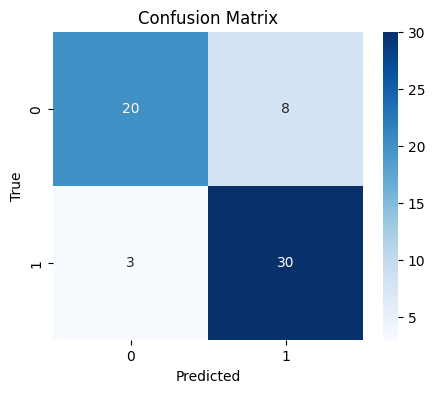

In [ ]:
# ------------------------------------------------------------
# 决策树模型预测与评估
# ------------------------------------------------------------

print("\n" + "="*50)
print("🔍 最优超参数:")
print("="*50)
for param, value in study.best_params.items():
    print(f"  • {param}: {value}")
print("="*50)

clf = DecisionTreeClassifier(**study.best_params, random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)

print("\n🎯 分类结果报告：")
print(classification_report(y_test, y_pred_tree))

print("✅ 准确率(Accuracy):", accuracy_score(y_test, y_pred_tree))

# 混淆矩阵可视化
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

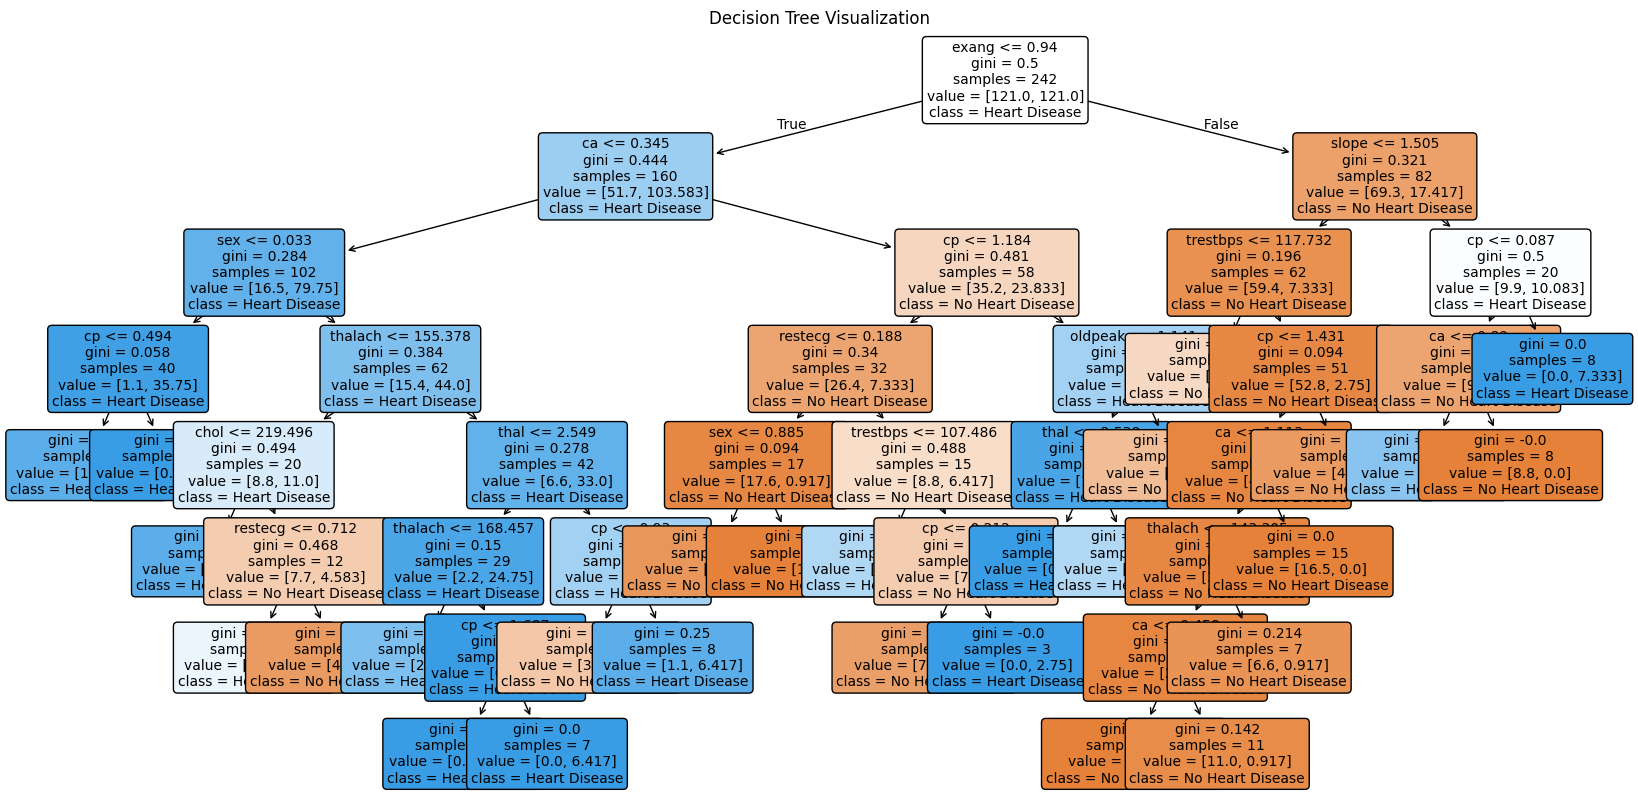

In [ ]:
# ------------------------------------------------------------
# 决策树可视化
# ------------------------------------------------------------
plt.figure(figsize=(20,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["No Heart Disease", "Heart Disease"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()

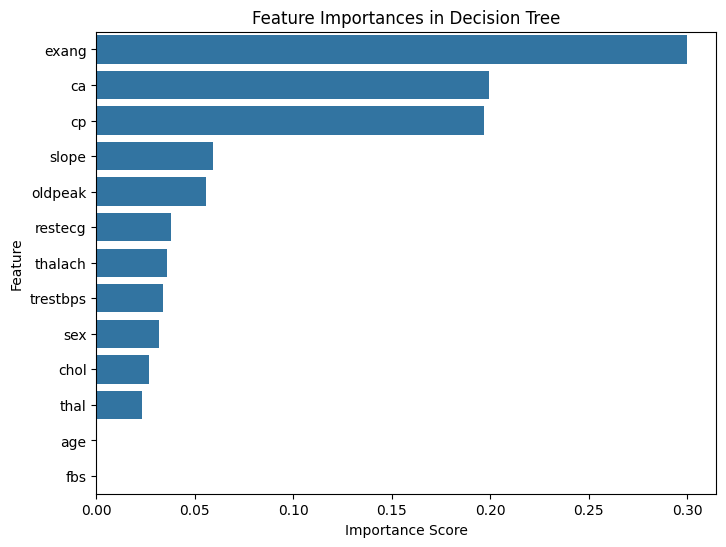


🏆 特征重要性：


exang       0.299774
ca          0.199332
cp          0.196740
slope       0.059381
oldpeak     0.055573
restecg     0.038039
thalach     0.035812
trestbps    0.033682
sex         0.031787
chol        0.026688
thal        0.023192
age         0.000000
fbs         0.000000
dtype: float64

In [ ]:
# ------------------------------------------------------------
# 特征重要性分析
# ------------------------------------------------------------
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\n🏆 特征重要性：")
display(importances)

### 5 随机森林模型训练、评估与分析

In [ ]:
# ------------------------------------------------------------
# 随机森林模型训练与评估
# ------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
print("\n🌲 开始训练随机森林模型...")

rf = RandomForestClassifier(
    n_estimators=200,   # 森林中树的数量
    max_depth=6,        # 限制树深度防止过拟合
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("✅ 随机森林模型训练完成！")
print("\n🎯 随机森林分类报告：")
print(classification_report(y_test, y_pred_rf))
print("✅ 随机森林准确率:", accuracy_score(y_test, y_pred_rf))


🌲 开始训练随机森林模型...
✅ 随机森林模型训练完成！

🎯 随机森林分类报告：
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61

✅ 随机森林准确率: 0.8360655737704918


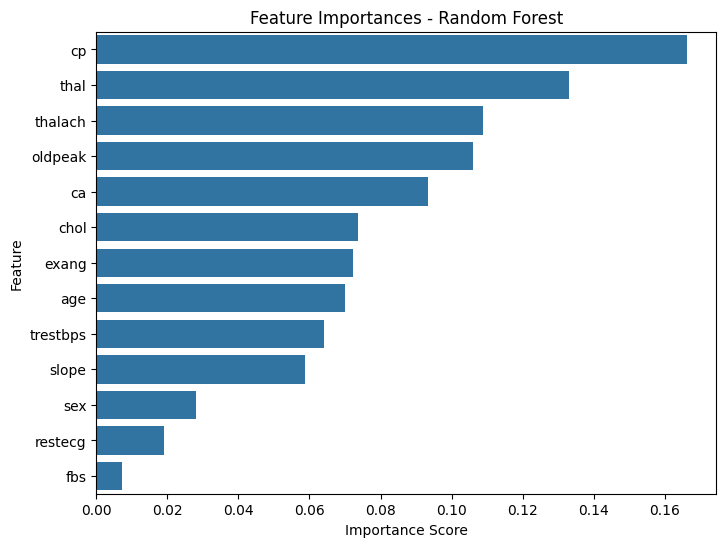


🏆 随机森林特征重要性：


cp          0.166163
thal        0.133019
thalach     0.108855
oldpeak     0.105976
ca          0.093383
chol        0.073539
exang       0.072171
age         0.069881
trestbps    0.064217
slope       0.058751
sex         0.027933
restecg     0.018955
fbs         0.007158
dtype: float64

In [ ]:
# ------------------------------------------------------------
# 随机森林特征重要性
# ------------------------------------------------------------
importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=importances_rf, y=importances_rf.index)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\n🏆 随机森林特征重要性：")
display(importances_rf)

### 6 KNN模型训练、预测、评估及可视化

In [ ]:
# ------------------------------------------------------------
# KNN 模型训练
# ------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
print("\n🔹 开始训练 KNN 模型...")

# KNN 对特征尺度敏感，因此需要标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 选择合适的邻居数（可调）
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

print("✅ KNN 模型训练完成！")


🔹 开始训练 KNN 模型...
✅ KNN 模型训练完成！



🎯 分类结果报告：
              precision    recall  f1-score   support

           0       0.71      0.36      0.48        28
           1       0.62      0.88      0.72        33

    accuracy                           0.64        61
   macro avg       0.67      0.62      0.60        61
weighted avg       0.66      0.64      0.61        61

✅ 准确率(Accuracy): 0.639344262295082


d:\Software\Anaconda\envs\Machine_learning_env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


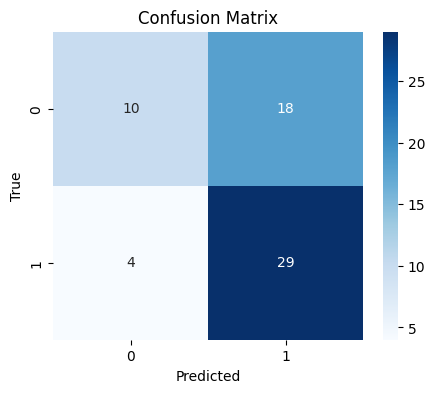

In [ ]:
# ------------------------------------------------------------
# 5️⃣ 模型预测与评估
# ------------------------------------------------------------
y_pred_knn = knn.predict(X_test)

print("\n🎯 分类结果报告：")
print(classification_report(y_test, y_pred_knn))

print("✅ 准确率(Accuracy):", accuracy_score(y_test, y_pred_knn))

# 混淆矩阵可视化
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 7 决策树、随机森林、KNN模型对比

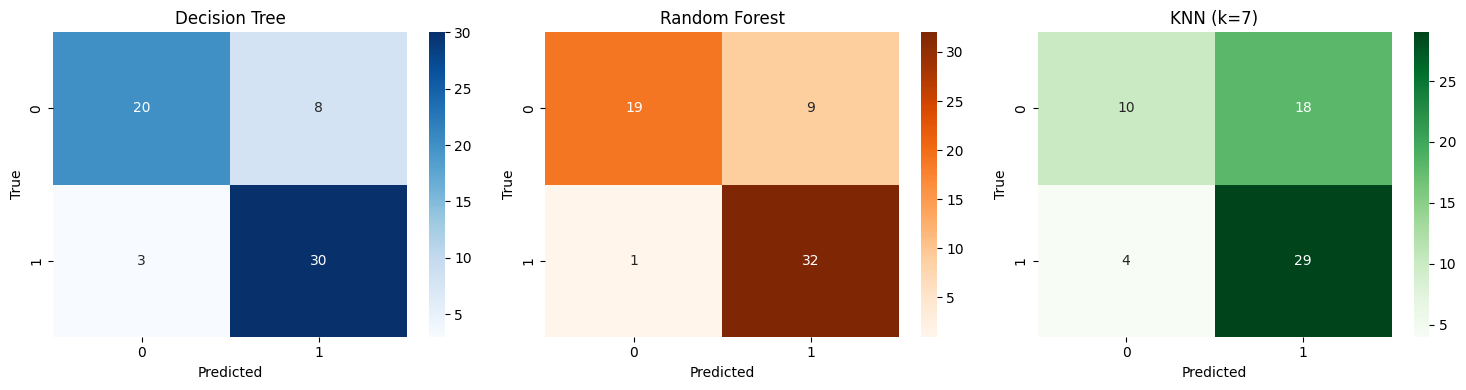

In [ ]:
# ------------------------------------------------------------
# 模型混淆矩阵对比
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Decision Tree")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Random Forest")

sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title("KNN (k=7)")


for ax in axes:
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


📊 模型性能对比：


,Model,Accuracy
0,Decision Tree,0.819672
1,KNN (k=7),0.639344
2,Random Forest,0.836066


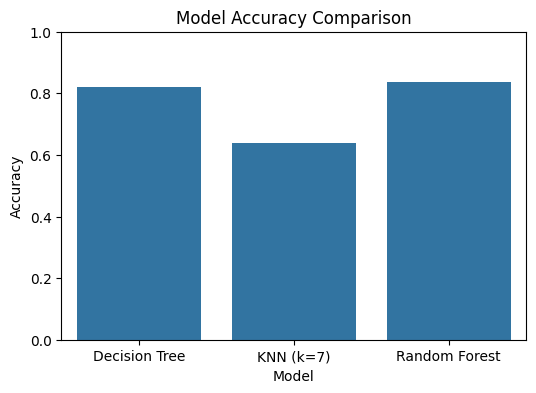

In [ ]:
# ------------------------------------------------------------
# 模型性能对比
# ------------------------------------------------------------
results = pd.DataFrame({
    "Model": ["Decision Tree", "KNN (k=7)", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_tree),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_rf)
    ]
})

print("\n📊 模型性能对比：")
display(results)

plt.figure(figsize=(6,4))
sns.barplot(data=results, x="Model", y="Accuracy")
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.show()